In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [4]:
import os
#from datetime import datetime

def pretraitement_knn():
    pathfile = r'ML/Uploads/data_anonymous/'

    # reflist: list of epc in each box
    reflist = pd.DataFrame()
    # 
    files=os.listdir(pathfile)
    for file in files:
        if file.startswith('reflist_'):
            temp=pd.read_csv(os.path.join(pathfile,file),sep=',').reset_index(drop=True)[['Epc']]
            temp['refListId']=file.split('.')[0]
            reflist = pd.concat([reflist, temp], axis = 0)
            #reflist=reflist.append(temp)
    reflist=reflist.rename(columns = {'refListId':'refListId_actual'})
    reflist['refListId_actual'] = reflist['refListId_actual'].apply(lambda x:int(x[8:]))

    Q_refListId_actual=reflist.groupby('refListId_actual')['Epc'].nunique().rename('Q refListId_actual').reset_index(drop=False)
    reflist=pd.merge(reflist,Q_refListId_actual,on='refListId_actual',how='left')
    
    df=pd.DataFrame()
    # 
    #files=os.listdir(pathfile)
    for file in files:
        if file.startswith('ano_APTags'):
       
            temp=pd.read_csv(os.path.join(pathfile,file),sep=',')
            df= pd.concat([df, temp], axis = 0)
    df['LogTime'] = pd.to_datetime (df['LogTime'] ,format='%Y-%m-%d-%H:%M:%S') 
    df['TimeStamp'] = df['TimeStamp'].astype(float)
    df['Rssi'] = df['Rssi'].astype(float)
    df=df.drop(['Reader','EmitPower','Frequency'],axis=1).reset_index(drop=True)
    df=df[['LogTime', 'Epc', 'Rssi', 'Ant']]
    # antennas 1 and 2 are facing the box when photocell in/out 
    Ant_loc=pd.DataFrame({'Ant':[1,2,3,4],'loc':['in','in','out','out']})
    df=pd.merge(df,Ant_loc,on=['Ant'])
    df=df.sort_values('LogTime').reset_index(drop=True)

    tags = df

        # timing: photocells a time window for each box: start/stop (ciuchStart, ciuchStop)
    file=r'ano_supply-process.2019-11-07-CUT.csv'
    timing=pd.read_csv(os.path.join(pathfile,file),sep=',')
    timing['file']=file
    timing['date']=pd.to_datetime(timing['date'],format='%d/%m/%Y %H:%M:%S,%f')
    timing['ciuchStart']=pd.to_datetime(timing['ciuchStart'],format='%d/%m/%Y %H:%M:%S,%f')
    timing['ciuchStop']=pd.to_datetime(timing['ciuchStop'],format='%d/%m/%Y %H:%M:%S,%f')
    timing['timestampStart']=timing['timestampStart'].astype(float)
    timing['timestampStop']=timing['timestampStop'].astype(float)
    timing=timing.sort_values('date')
    timing.loc[:,'refListId']=timing.loc[:,'refListId'].apply(lambda x:int(x[8:]))
    timing=timing[['refListId', 'ciuchStart', 'ciuchStop']]
    
    
        # ciuchStart_up starts upstream ciuchStart, half way in between the previous stop and the actual start
    timing[['ciuchStop_last']]=timing[['ciuchStop']].shift(1)
    timing[['refListId_last']]=timing[['refListId']].shift(1)
    timing['ciuchStartup']=timing['ciuchStart'] - (timing['ciuchStart'] - timing['ciuchStop_last'])/2
    # timing start: 10sec before timing
    timing.loc[0,'refListId_last']=timing.loc[0,'refListId']
    timing.loc[0,'ciuchStartup']=timing.loc[0,'ciuchStart']-datetime.timedelta(seconds=10)
    timing.loc[0,'ciuchStop_last']=timing.loc[0,'ciuchStartup']-datetime.timedelta(seconds=10)
    timing['refListId_last']=timing['refListId_last'].astype(int)
    # 
    timing['ciuchStopdown']= timing['ciuchStartup'].shift(-1)
    timing.loc[len(timing)-1,'ciuchStopdown']=timing.loc[len(timing)-1,'ciuchStop']+datetime.timedelta(seconds=10)
    timing=timing[['refListId', 'refListId_last','ciuchStartup', 'ciuchStart','ciuchStop','ciuchStopdown']]
    
    
        # t0_run = a new run starts when box 0 shows up
    t0_run=timing[timing['refListId']==0] [['ciuchStartup']]
    t0_run=t0_run.rename(columns={'ciuchStartup':'t0_run'})
    t0_run=t0_run.groupby('t0_run').size().cumsum().rename('run').reset_index(drop=False)
    t0_run=t0_run.sort_values('t0_run')
    # 
    # each row in timing is merged with a last row in t0_run where t0_run (ciuchstart) <= timing (ciuchstart)
    timing=pd.merge_asof(timing,t0_run,left_on='ciuchStartup',right_on='t0_run', direction='backward')
    timing=timing.sort_values('ciuchStop')
    timing=timing[['run', 'refListId', 'refListId_last', 'ciuchStartup','ciuchStart','ciuchStop','ciuchStopdown','t0_run']]

    
    slices = pd.DataFrame()
    for i, row in timing.iterrows():
        ciuchStartup = row['ciuchStartup']
        ciuchStart = row['ciuchStart']
        ciuchStop = row['ciuchStop']
        ciuchStopdown = row['ciuchStopdown']
        steps = 3

        # Cr�ation des tranches "up"
        up = pd.DataFrame(index=pd.date_range(start=ciuchStartup, end=ciuchStart, periods=steps)) \
            .reset_index(drop=False).rename(columns={'index': 'slice'})
        up['slice_id'] = ['up_' + str(x) for x in range(steps)]
        slices = pd.concat([slices, up], ignore_index=True)

        # Cr�ation des tranches "mid"
        mid = pd.DataFrame(index=pd.date_range(start=ciuchStart, end=ciuchStop, periods=steps)) \
            .reset_index(drop=False).rename(columns={'index': 'slice'})
        mid['slice_id'] = ['mid_' + str(x) for x in range(steps)]
        slices = pd.concat([slices, mid], ignore_index=True)

        # Cr�ation des tranches "down"
        down = pd.DataFrame(index=pd.date_range(start=ciuchStop, end=ciuchStopdown, periods=steps)) \
            .reset_index(drop=False).rename(columns={'index': 'slice'})
        down['slice_id'] = ['down_' + str(x) for x in range(steps)]
        slices = pd.concat([slices, down], ignore_index=True)

    slices.reset_index(drop=False, inplace=True)

    # 
    timing_slices=pd.merge_asof(slices,timing,left_on='slice',right_on='ciuchStartup',direction='backward')
    timing_slices=timing_slices[['run', 'refListId', 'refListId_last','slice_id','slice',  \
                                 'ciuchStartup', 'ciuchStart', 'ciuchStop', 'ciuchStopdown','t0_run']]
    
    # merge between df and timing
    # merge_asof needs sorted df > df_ref
    df=df[ (df['LogTime']>=timing['ciuchStartup'].min()) & (df['LogTime']<=timing['ciuchStopdown'].max())  ]
    df=df.sort_values('LogTime')
    # 
    # each row in df_ref is merged with the last row in timing where timing (ciuchstart_up) < df_ref (logtime)
    # 
    # df_timing=pd.merge_asof(df_ref,timing,left_on=['LogTime'],right_on=['ciuchStartup'],direction='backward')
    # df_timing=df_timing.dropna()
    # df_timing=df_timing.sort_values('LogTime').reset_index(drop=True)
    # df_timing=df_timing[['run', 'Epc','refListId', 'refListId_last', 'ciuchStartup',\
    #                      'LogTime', 'ciuchStop', 'ciuchStopdown','Rssi', 'loc', 'refListId_actual']]
    # 
    # each row in df_ref is merged with the last row in timing_slices where timing (slice) < df_ref (logtime)
    # 
    df_timing_slices=pd.merge_asof(df,timing_slices,left_on=['LogTime'],right_on=['slice'],direction='backward')
    df_timing_slices=df_timing_slices.dropna()
    df_timing_slices=df_timing_slices.sort_values('slice').reset_index(drop=True)
    df_timing_slices=df_timing_slices[['run', 'Epc','refListId', 'refListId_last', 'ciuchStartup','slice_id','slice','LogTime', \
                          'ciuchStart','ciuchStop', 'ciuchStopdown', 'Rssi', 'loc','t0_run']]
    df_timing_slices['reflist_run_id'] = df_timing_slices['refListId'].astype(str) +"_"+ df_timing_slices['run'].astype(str)
    
    # runs 16 23 32 40 have missing boxes: discarded
    # also run 1 is the start, no previous box: discarded
    # run 18: box 0 run at the end
    # 
    timing=timing[~timing['run'].isin([1,18,16,23,32,40])]
    timing_slices=timing_slices[~timing_slices['run'].isin([1,18,16,23,32,40])]
    df_timing_slices=df_timing_slices[~df_timing_slices['run'].isin([1,18,16,23,32,40])]

    df_timing_slices=df_timing_slices.sort_values(['LogTime','Epc'])
    
    # df_timing_slices['dt']=
    df_timing_slices['dt']=(df_timing_slices['LogTime']-df_timing_slices['t0_run']).apply(lambda x:x.total_seconds())
    
    timing['reflist_run_id']= timing['refListId'].astype(str)+"_"+ timing['run'].astype(str)
    timing['window_width']=(timing['ciuchStopdown']-timing['ciuchStartup']).apply(lambda x:x.total_seconds())
    windows=timing[['reflist_run_id', 'window_width']]
    rssi_quantite=1
    return [df_timing_slices, windows,rssi_quantite,reflist]


def dataset(df_timing_slices, windows, rssi_quantite):
    ds_rssi = df_timing_slices.groupby(['Epc', 'reflist_run_id', 'slice_id', 'loc'])['Rssi'].quantile(rssi_quantite) \
                 .unstack(['slice_id', 'loc'], fill_value=-110)
    ds_rssi.columns = [x[0] + '_' + x[1] for x in ds_rssi.columns]
    ds_rssi = ds_rssi.reset_index(drop=False)
    
    ds_rc = df_timing_slices.groupby(['Epc', 'reflist_run_id', 'slice_id', 'loc']).size() \
               .unstack(['slice_id', 'loc'], fill_value=0)
    ds_rc.columns = [x[0] + '_' + x[1] for x in ds_rc.columns]
    ds_rc = ds_rc.reset_index(drop=False)
    
    ds = pd.merge(ds_rssi, ds_rc, on=['Epc', 'reflist_run_id'], suffixes=['_rssi', '_rc'])
    ds = pd.merge(ds, windows, on='reflist_run_id', how='left')
    
    Q_Epcs_window = df_timing_slices.groupby(['reflist_run_id'])['Epc'].nunique().rename('Epcs_window').reset_index(drop=False)
    ds = pd.merge(ds, Q_Epcs_window, on='reflist_run_id', how='left')
    
    Q_reads_window = df_timing_slices.groupby(['reflist_run_id']).size().rename('reads_window').reset_index(drop=False)
    ds = pd.merge(ds, Q_reads_window, on='reflist_run_id', how='left')
    
    ds=pd.merge(ds, pretraitement_knn()[3], on='Epc', how='left')
    ds['actual']=ds['reflist_run_id'].apply(lambda x: x.split ('_')[0]).astype('int64')== ds['refListId_actual']
    ds['actual'] = ds ['actual'].replace({True: 'IN' , False: 'OUT'})
    
    return ds
#data = pretraitement_knn()
#colonne=dataset(pretraitement_knn()[0],pretraitement_knn()[1],pretraitement_knn()[2]).columns


def Xcols_func(features, Xcols_all):
    Features=pd.DataFrame(\
        [\
         ['all', True, True, False, True, True, True],\
         ['rssi & rc only', True, True, False, False, False, False],\
         ['rssi & rc_mid', True, True, True, False, False, False],\
         ['rssi only', True, False, True, False, False, False],\
         ['rc only', False, True, False, False, False, False],\
        ], columns=['features', 'rssi', 'rc', 'rc_mid_only', 'Epcs_window', 'reads_window', 'window_width'])
    Features

    Features_temp = Features[Features['features']==features]
    
    X=[]
    rssi = Features_temp ['rssi'].values[0]
    rc = Features_temp['rc'].values[0]
    rc_mid_only = Features_temp['rc_mid_only'].values[0]
    Epcs_window =  Features_temp['Epcs_window'].values[0]
    reads_window =  Features_temp['reads_window'].values[0]
    window_width =  Features_temp['window_width'].values[0]
    
    colonne = Xcols_all
    
    X_rssi = [x for x in colonne if rssi*'rssi' in x.split('_')]
    X_rc = [x for x in colonne if rc*'rc' in x.split('_')]
    
    X = X_rssi + X_rc
    
    if Epcs_window:
        X.append('Epcs_window')
    if reads_window:
        X.append('reads_window')
    if window_width:
        X.append('window_width')
        
    return X

In [5]:
estimators = list(range(1,90))
depth = list(range(1,45))
leaves = list(range(1,45))

In [6]:
neighbors = list(range(1,26))
weights = ["uniform", "distance"]
metrics = ["minkowski", "euclidean", "manhattan"]

In [7]:
rf, svm, knn = RandomForestClassifier(), SVC(), KNeighborsClassifier()

In [10]:
import os

In [8]:
len(C)

NameError: name 'C' is not defined

In [5]:
# Getting the data
start_time = datetime.datetime.now()
data = pretraitement_knn() 
ds = dataset(data[0],data[1],data[2])
end_time = datetime.datetime.now()
print('Duree de pretraitement_knn {}'.format(end_time - start_time))

C:\Users\46425238\AppData\Local\Temp\ipykernel_3884\2680203562.py:53: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  timing.loc[:,'refListId']=timing.loc[:,'refListId'].apply(lambda x:int(x[8:]))
C:\Users\46425238\AppData\Local\Temp\ipykernel_3884\2680203562.py:53: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  timing.loc[:,'refListId']=timing.loc[:,'refListId'].apply(lambda x:int(x[8:]))


Duree de pretraitement_knn 0:00:09.197838


In [6]:
ds

,Epc,reflist_run_id,down_0_out_rssi,down_1_out_rssi,up_1_out_rssi,mid_0_out_rssi,mid_1_out_rssi,up_0_out_rssi,down_0_in_rssi,down_1_in_rssi,...,mid_0_in_rc,mid_1_in_rc,up_1_in_rc,up_0_in_rc,window_width,Epcs_window,reads_window,refListId_actual,Q refListId_actual,actual
0,epc_0,0_10,-67.0,-63.0,-64.0,-110.0,-110.0,-110.0,-110.0,-110.0,...,0,0,0,0,11.4625,74,1526,5,40,OUT
1,epc_0,0_19,-69.0,-110.0,-110.0,-68.0,-110.0,-110.0,-110.0,-110.0,...,0,0,0,0,15.7040,72,2241,5,40,OUT
2,epc_0,0_21,-65.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,...,0,0,0,0,6.0845,71,897,5,40,OUT
3,epc_0,0_27,-69.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,...,0,0,0,0,5.8215,55,740,5,40,OUT
4,epc_0,0_29,-65.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,...,0,0,0,0,5.7655,61,708,5,40,OUT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24402,epc_99,9_5,-48.0,-50.0,-110.0,-110.0,-64.0,-110.0,-66.0,-66.0,...,0,0,0,0,6.7370,78,841,0,16,OUT
24403,epc_99,9_6,-47.0,-47.0,-59.0,-46.0,-43.0,-56.0,-62.0,-61.0,...,2,6,0,0,5.9590,70,831,0,16,OUT
24404,epc_99,9_7,-44.0,-47.0,-110.0,-63.0,-51.0,-110.0,-70.0,-63.0,...,0,0,0,0,5.7060,69,718,0,16,OUT
24405,epc_99,9_8,-46.0,-44.0,-110.0,-64.0,-56.0,-110.0,-68.0,-67.0,...,0,0,0,0,5.6160,63,674,0,16,OUT


In [7]:
# Getting X and y 
X = ds[Xcols_func('all',ds.columns)]
y = pd.DataFrame(LabelEncoder().fit_transform(ds['actual']))

C:\Users\46425238\AppData\Local\Temp\ipykernel_3884\2680203562.py:211: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  X_rssi = [x for x in colonne if rssi*'rssi' in x.split('_')]
C:\Users\46425238\AppData\Local\Temp\ipykernel_3884\2680203562.py:212: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  X_rc = [x for x in colonne if rc*'rc' in x.split('_')]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [27]:
pd.Series(y).value_counts()

1    17539
0     6868
dtype: int64

In [15]:
rf = RandomForestClassifier()
grid = GridSearchCV(rf,rf_params)
# n_jobs will help gridsearchCV to run faster and properly

In [ ]:
grid.fit(X_train, y_train)

MemoryError: 

In [65]:
grid.best_params_

{'max_depth': 17, 'min_samples_leaf': 1, 'n_estimators': 33}

In [13]:
def plot_validation_curves(model, train_X, train_y, hyper_parameter:str, parameter_range, 
                           folders:int, savepath:str):
    start = datetime.datetime.now()
    
    train_scores, val_scores = validation_curve(model, train_X, train_y, param_name = hyper_parameter,
                                                     param_range = np.array(parameter_range), cv = folders)
    
    # curves 
    plt.plot(parameter_range, train_scores, 'y-', label = "score à l\'entrainement")
    plt.plot(parameter_range, val_scores, 'r-', label = "score à la validation")
     
    # Ajouter un titre et des légendes pour l'axe x et l'axe y
    plt.title('Précision de '+ type(model).__name__ + 'en fonction de ' + hyper_parameter ) # titre
    plt.xlabel('Valeurs de ' + hyper_parameter) # légende de l'axe des abscisses
    plt.ylabel('Valeurs de précision') # légende de l'axe des ordonées
    
    # légende
    plt.legend() 
    plt.grid(True)
    
    # Sauvegarde des graphes
    plt.savefig(savepath, dpi = 300)
    
    #print('min22 :',df_month['value22'].max(),'\nMin23 :', df_month['value23'].max())
    plt.show() # Affichage de la figure
    end = datetime.datetime.now()
    print('Duree de curve_validation_plot : {}'.format(end-start))
    

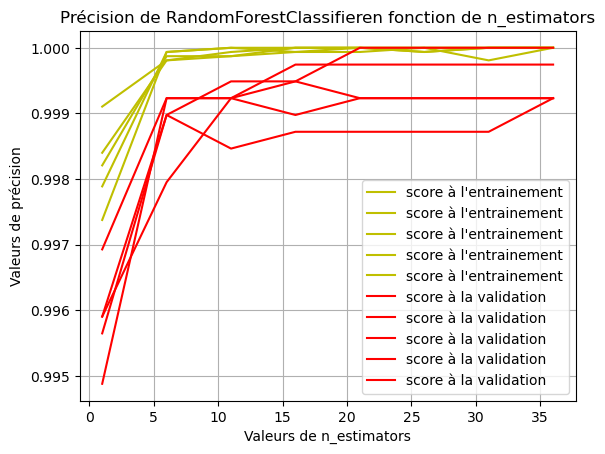

Duree de curve_validation_plot : 0:00:18.412926


In [48]:
rf = RandomForestClassifier(max_depth = 17, min_samples_leaf= 1)
plot_validation_curves(rf, X_train, y_train, 'n_estimators', list(range(1, 40, 5)), 5,\
                          'ML/courbes/RandomForest/n_estimators')

In [ ]:
rf = RandomForestClassifier(max_depth = 17, n_estimators = 33)
plot_validation_curves(rf, X_train, y_train, 'min_samples_leaf', list(range(1, 10)), 5,\
                          'ML/courbes/RandomForest/min_samples_leaf')

In [ ]:
rf = RandomForestClassifier(min_samples_leaf = 1, n_estimators = 33)
plot_validation_curves(rf, X_train, y_train, 'max_depth', list(range(1, 20)), 5,\
                          'ML/courbes/RandomForest/max_depth')

In [47]:
grid_knn = GridSearchCV(knn,hp["KNN"] , cv = 5, n_jobs = 4, verbose = 2)

In [49]:
print(datetime.datetime.now())

2024-04-25 20:22:04.311792


In [50]:
grid_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}

In [48]:
C =  [ round(x * 0.05, 3) for x in range(20)] + [round(x * 0.2, 3) for x in range(5,15)]
gammas = ['scale']
kernels = ['rbf']
# gammas = ['scale', 'auto']
# kernels = ['rbf','linear','poly', 'sygmoid']

In [50]:
hp = {
    "RandomForest":{"n_estimators" :estimators, "max_depth":depth, "min_samples_leaf":leaves},
    "SVM" : {"gamma":gammas, "C":C, "kernel":kernels},
    "KNN" : {"n_neighbors":neighbors,"weights":weights, "metric":metrics }
}

In [49]:
rf_params = {
    "n_estimators":list(range(1,70)),
    "max_depth":list(range(1,45)),
    "min_samples_leaf":list(range(1,45)),
    'criterion_index' : ["gini","entropy","log_loss"],
    "min_samples_split_index":list(range(1,70)),
    "min_weight_fraction_leaf_index": [x*0.05 for x in range(1,10)],
    "max_features_index": ['sqrt','log2',None],
    "max_leaf_nodes_index":[x for x in range(2,40)],
     "min_impurity_decrease_index": [x * 0.25 for x in range(1,40)],
     "bootstrap_index":[True,False],
     "oob_score_index":[True,False],
      "n_jobs_index": [x for x in range(1,30)],
      "random_state_index":[x for x in range(1,30)],
       "verbose_index":[x for x in range(1,20)],
       "warm_start_index": [True,False],
       "class_weight_index": ["balanced", "balanced_subsample"],
      "ccp_alpha_index":[x * 0.25 for x in range(1,40)],
        "max_samples_index": [x for x in range(1,30)]    
}

In [64]:
svm_params = {
    "C":[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4,
                               0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,
                               0.9, 0.95, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2,
                               2.4, 2.6, 2.8],
    "coef0": [ x for x in range(1,100)],
    "tol":[ x * 0.25 for x in range(1,34)],
    "cache_size" : [x  for x in range(5,10,205)],
    "max_iter":[x  for x in range(1,70)],
    "random_state" :[ None] + [ x for x in range(65)]
}

In [61]:
for a in svm_params.keys():
    print(a)

C
coef0
tol
cache_size
max_iter
random_state


In [ ]:
# start = datetime.datetime.now()

scores = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
x_line = svm_params["coef0"]
for p in x_line: 
    rf = SVC(C = 1, gamma='scale', kernel = 'rbf', coef0 =p)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores.append(acc)
print(x_line,scores)
plt.plot(x_line, scores, 'r-')
plt.title("Précision de SVM en fonction de coef0")
plt.grid(True)
plt.savefig("coef0.png", dpi=300)
plt.show()
# duree_rf_ = datetime.datetime.now() - start
# print ("Temps pour obtenir la courbe : {} ".format(duree_rf_))

C:\logiciels\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\logiciels\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\logiciels\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\logiciels\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

In [39]:
plt.plot(estimators, scores, 'r.-')
plt.title("Précision du RandomForest en fonction de n_estimators")
plt.grid(True)
plt.savefig("ML/courbes/precision/RandomForest/n_estimators.png", dpi=300)
plt.show()

NameError: name 'estimators' is not defined

In [51]:
grid_svm = GridSearchCV(svm,hp["SVM"] , cv = 2, n_jobs = 4, verbose = 2)

In [52]:
grid_svm.fit(X_train,y_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


C:\logiciels\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\logiciels\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\logiciels\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 180, in fit
    self._validate_params()
  File "C:\logiciels\anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "C:\logiciels\anaconda3\lib\site-packages\sklearn\utils\_pa

GridSearchCV(cv=2, estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4,
                               0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,
                               0.9, 0.95, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2,
                               2.4, 2.6, 2.8],
                         'gamma': ['scale'], 'kernel': ['rbf']},
             verbose=2)

In [53]:
grid_svm.best_params_

{'C': 2.8, 'gamma': 'scale', 'kernel': 'rbf'}

In [55]:
svm = SVC(gamma = 'scale', kernel = 'rbf')

In [ ]:
train_scores, val_scores = validation_curve(svm, X_train, y_train, param_name = "C",
                                                     param_range = np.array(hp['SVM']['C']), cv = 2)
    
# curves 
plt.plot(np.array(hp['SVM']['C']), train_scores, 'y-', label = "score à l\'entrainement")
plt.plot(np.array(hp['SVM']['C']), val_scores, 'r-', label = "score à la validation")

# Ajouter un titre et des légendes pour l'axe x et l'axe y
plt.title('Précision de '+ type(svm).__name__ + ' en fonction de ' + 'C' ) # titre
plt.xlabel('Valeurs de ' + 'C') # légende de l'axe des abscisses
plt.ylabel('Valeurs de précision') # légende de l'axe des ordonées

# légende
plt.legend() 
plt.grid(True)

# Sauvegarde des graphes
plt.savefig('C.png', dpi = 300)

#print('min22 :',df_month['value22'].max(),'\nMin23 :', df_month['value23'].max())
plt.show() # Affichage de la figure


C:\logiciels\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\logiciels\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\logiciels\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\logiciels\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

In [ ]:
train_scores, val_scores = validation_curve(rf, X_train, y_train, param_name = 'n_estimators',
                                            param_range = np.array(neighbors), cv = 7)

In [ ]:
plt.figure(figsize = (14,10))
plt.plot(np.array(neighbors), train_scores, 'y+', label = "score à l\'entrainement")
#plt.plot(np.array(neighbors), val_scores, 'r-', label = "score à la validation")
plt.show()

In [ ]:
plot_validation_curves('RandomForest',X_train, y_train, 'max_depth', depth, 5)